### Retrieve SDFs from directory (downloaded from Fragalysis)

In [1]:
import os
from rdkit import Chem


def get_sdfs(dir_name):
    
    sdf_files = []
    filenames = []

    # collect sdf files from dirs
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            if file.endswith(".sdf"):
                # ignore combined sdf file
                if 'Mpro_combined' not in file:
                    sdf_files.append(os.path.join(root, file))
                    filenames.append(file)

    return sdf_files, filenames

### Convert SDFs to rdkit mol objects

https://www.rdkit.org/docs/GettingStartedInPython.html

In [2]:
# get mol object for each sdf file

def sdf_to_mol(sdf_file_list):
   
   mols = []
   for sdf_file in sdf_file_list:
      with Chem.SDMolSupplier(sdf_file) as suppl:
         for mol in suppl:
            if mol is None: continue
            mols.append(mol)

   return mols


### Extract pharmacophores and their types and coordinates
http://rdkit.blogspot.com/2017/11/using-feature-maps.html 

In [3]:
# code to generate pharmacophores
import numpy as np
from rdkit import RDConfig, Chem
from rdkit.Chem import AllChem
from collections import defaultdict

# feature factory defines set of pharmacophore features being used 
_FEATURES_FACTORY, _FEATURES_NAMES = [], []

def get_features_factory(features_names, resetPharmacophoreFactory=False):

    global _FEATURES_FACTORY, _FEATURES_NAMES

    if resetPharmacophoreFactory or (len(_FEATURES_FACTORY) > 0 and _FEATURES_FACTORY[-1] != features_names):
        _FEATURES_FACTORY.pop()
       # _FEATURES_FACTORY.pop() # NOTE repeated line?
    if len(_FEATURES_FACTORY) == 0:
        feature_factory = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))
        _FEATURES_NAMES = features_names
        if features_names is None:
            features_names = list(feature_factory.GetFeatureFamilies())

        _FEATURES_FACTORY.extend([feature_factory, features_names])

    return _FEATURES_FACTORY

In [4]:
# NOTE ask re conformers here vs for query mols

def getPharmacophoreCoords(mol, features_names=["Acceptor", "Donor", "Aromatic"], confId=-1):

    # find features of a molecule
    feature_factory, keep_featnames = get_features_factory(features_names)
    rawFeats = feature_factory.GetFeaturesForMol(mol, confId=confId)
    featsDict = defaultdict(list)
    idxsDict = defaultdict(list)

    for f in rawFeats:
        if f.GetFamily() in keep_featnames:
            featsDict[f.GetFamily()].append(np.array(f.GetPos(confId=f.GetActiveConformer())))
            idxsDict[f.GetFamily()].append(np.array(f.GetAtomIds()))

    new_feats_dict = {}
    for key in featsDict:
        new_feats_dict[key] = np.concatenate(featsDict[key]).reshape((-1,3))
    
    return new_feats_dict, idxsDict


Below functions similar but slightly different:
- one gets all coordinates for all mols, to collect coordinates for fragment cloud
- the second gets coordinates for a single mol which is more useful when dealing with the query molecules

In [5]:
# compute pharmacophores coordinates
# NOTE should change just to work for one molecule rather than looping through

def get_coords(mols):

    donor_coords = []
    acceptor_coords = []
    aromatic_coords = []

    for mol in mols:
        # .get() will just fill with None if key doesn't exist
        pharma_coords, __ = getPharmacophoreCoords(mol)
        donor_coord = pharma_coords.get('Donor')
        acceptor_coord = pharma_coords.get('Acceptor')
        aromatic_coord = pharma_coords.get('Aromatic')

        donor_coords.append(donor_coord)
        acceptor_coords.append(acceptor_coord)
        aromatic_coords.append(aromatic_coord)

    # remove None values
    donor_coords = [x for x in donor_coords if x is not None]
    acceptor_coords = [x for x in acceptor_coords if x is not None]
    aromatic_coords = [x for x in aromatic_coords if x is not None]

    if len(donor_coords) == 0:
        donor_coords = donor_coords
    else: 
        donor_coords = np.concatenate(donor_coords)
    
    if len(acceptor_coords) == 0:
        acceptor_coords = acceptor_coords
    else:
        acceptor_coords = np.concatenate(acceptor_coords)

    if len(aromatic_coords) == 0:
        aromatic_coords = aromatic_coords
    else:
        aromatic_coords = np.concatenate(aromatic_coords)

    return donor_coords, acceptor_coords, aromatic_coords


In [6]:
def get_coords_query(mol):

    donor_coords = []
    acceptor_coords = []
    aromatic_coords = []
    
    # .get() will just fill with None if key doesn't exist
    pharma_coords, __ = getPharmacophoreCoords(mol)
    donor_coords = pharma_coords.get('Donor')
    acceptor_coords = pharma_coords.get('Acceptor')
    aromatic_coords = pharma_coords.get('Aromatic')

    # remove None values
    if donor_coords is not None:
        donor_coords = [x for x in donor_coords if x is not None]
        donor_coords = np.concatenate([donor_coords])
    if acceptor_coords is not None:
        acceptor_coords = [x for x in acceptor_coords if x is not None]
        acceptor_coords = np.concatenate([acceptor_coords])
    if aromatic_coords is not None:
        aromatic_coords = [x for x in aromatic_coords if x is not None]
        aromatic_coords = np.concatenate([aromatic_coords])

    return donor_coords, acceptor_coords, aromatic_coords

### Setting up fragment point cloud

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_coords(donor_coords, acceptor_coords, aromatic_coords):
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    # visualize the 3D cloud of fragment pharmacophores. They are a good representation of the protein pocket.
    labels = ['Donor', 'Acceptor', 'Aromatic']
    for coords, label in zip([donor_coords, acceptor_coords, aromatic_coords], labels):
        if len(coords) != 0:
            ax.scatter3D(coords[:,0], coords[:,1], coords[:,2], label=label)

    plt.legend()
    plt.show()

    return

67
31


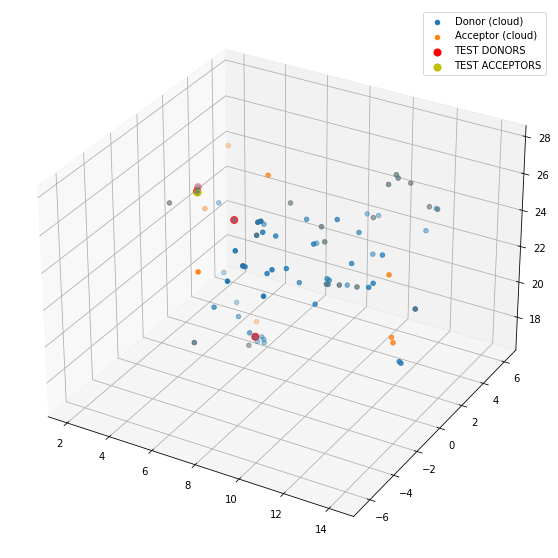

In [35]:
# run above functions
fragment_files, frag_filenames = get_sdfs('Mpro_fragments')
frag_mols = sdf_to_mol(fragment_files)
frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords = get_coords(frag_mols)
#plot_coords(frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords)

# NOTE ~20 fragments, number of ph4s will obvs be different
# like 67 donors, 31 acceptors
print(len(frag_donor_coords)) 
print(len(frag_acceptor_coords))

test_donor_coords, test_acceptor_coords, test_aromatic_coords = get_coords_query(frag_mols[0])

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

# visualize the 3D cloud of fragment pharmacophores. They are a good representation of the protein pocket.
labels = ['Donor (cloud)', 'Acceptor (cloud)', 'Aromatic']
for coords, label in zip([frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords], labels):
    if len(coords) != 0:
        ax.scatter3D(coords[:,0], coords[:,1], coords[:,2], label=label)
ax.scatter3D(test_donor_coords[:,0], test_donor_coords[:,1], test_donor_coords[:,2], label='TEST DONORS', c='r', s=50)
ax.scatter3D(test_acceptor_coords[:,0], test_acceptor_coords[:,1], test_acceptor_coords[:,2], label='TEST ACCEPTORS', c='y', s=50)
plt.legend()
plt.show()


### Setting up fragment to align against fragments (test)

- set up ph4 fragment cloud like normal
- get ph4 points for one of the fragments
- transform those ph4 points
- map those points back to the cloud


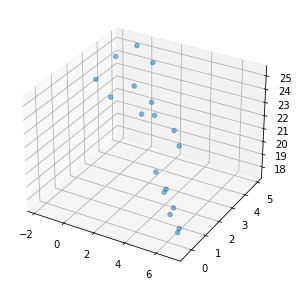

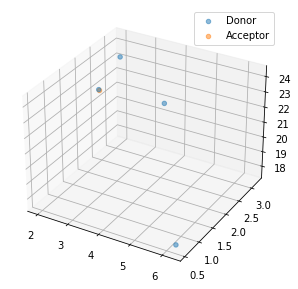

In [15]:
# just get first fragment in files
test_donor_coords, test_acceptor_coords, test_aromatic_coords = get_coords_query(frag_mols[0])
test_points = np.concatenate([test_donor_coords, test_acceptor_coords])

# all coords of fragment (not just ph4s)
frag_test_mol_coords = frag_mols[0].GetConformer().GetPositions()

# plot
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.scatter3D(frag_test_mol_coords[:,0], frag_test_mol_coords[:,1], frag_test_mol_coords[:,2], alpha=0.5)
plt.show()

# get ph4 of fragment
test_donor_coords, test_acceptor_coords, test_aromatic_coords = get_coords_query(frag_mols[0])

# plot ph4s
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.scatter3D(test_donor_coords[:,0], test_donor_coords[:,1], test_donor_coords[:,2], label='Donor', alpha=0.5)
ax.scatter3D(test_acceptor_coords[:,0], test_acceptor_coords[:,1], test_acceptor_coords[:,2], label='Acceptor', alpha=0.5)
plt.legend()
plt.show()


Transform coordinates of the fragment test molecule:

https://en.wikipedia.org/wiki/Rotation_matrix (scroll down for 'basic rotation')

In [10]:
def rot_ar_x(radi):
    return  np.array([[1, 0, 0], 
            [0, np.cos(radi), -np.sin(radi)], 
            [0, np.sin(radi), np.cos(radi)],], 
            dtype=np.double)

def rot_ar_y(radi):
    return  np.array([[np.cos(radi), 0, np.sin(radi)], 
            [0, 1, 0], 
            [-np.sin(radi), 0, np.cos(radi)],], 
            dtype=np.double)

def rot_ar_z(radi):
    return  np.array([[np.cos(radi), -np.sin(radi), 0], 
            [np.sin(radi), np.cos(radi), 0], 
            [0, 0, 1],], 
            dtype=np.double)

# transform fragment test ph4 coords by applying rotation matrices ? 
rot_matrix_x = rot_ar_x(np.pi)
rot_matrix_y = rot_ar_y(np.pi)
rot_matrix_z = rot_ar_y(np.pi)
rot_matrices = [rot_matrix_x, rot_matrix_y, rot_matrix_z]

test_points = frag_ph4_coords@rot_matrix_x
test_points = test_points@rot_matrix_y
test_points = test_points@rot_matrix_z

print(frag_ph4_coords)
print(test_points)

[[ 4.199  2.401 22.489]
 [ 6.244  0.543 17.664]
 [ 1.978  3.214 23.166]
 [ 3.015  1.422 24.221]
 [ 3.015  1.422 24.221]]
[[  4.199  -2.401 -22.489]
 [  6.244  -0.543 -17.664]
 [  1.978  -3.214 -23.166]
 [  3.015  -1.422 -24.221]
 [  3.015  -1.422 -24.221]]


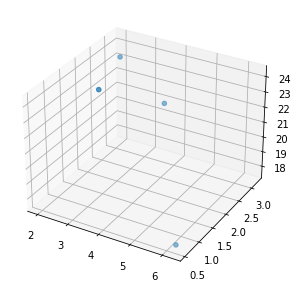

In [16]:
# plot to check transformed
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.scatter3D(test_points[:,0], test_points[:,1], test_points[:,2], alpha=0.5)
plt.show()

### Align transformed fragment back to fragment cloud 

- generate permutations of the relevant fragment points
- use code from most recent brute force draft (12/5/22)

In [10]:
import kabsch_functions_new as kabsch
import numpy as np
import scipy
import pandas as pd
import itertools


### Clustering

*unfinished*
- hierarchical clustering; use agglomerative clustering (sklearn)
- aim to reduce number of points in fragment point cloud if high density in particular areas
- 20 fragments with 98 points reduced to 36 clusters; if cluster also by ph4 type get 33 donor clusters and 18 acceptor clusters (no aromatic points)


https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/ - stuff on distance b/t clusters


In [17]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
def cluster(data, distance_threshold):

    model = AgglomerativeClustering(linkage='average', n_clusters=None, distance_threshold=distance_threshold) # 0.5 - 1 
    model.fit_predict(data)
    pred = model.fit_predict(data)
    print("Number of clusters found: {}".format(len(set(model.labels_))))
    labels = model.labels_
    print('Cluster for each point: ', model.labels_)

    return labels


In [18]:
# cluster donor coords and add with labels to df
labels = cluster(frag_donor_coords, distance_threshold=1)
donor_df = pd.DataFrame([frag_donor_coords[:,0], frag_donor_coords[:,1], frag_donor_coords[:,2], labels])
donor_df = donor_df.transpose()
donor_df.columns = ['x', 'y', 'z', 'cluster_label']

# cluster acceptor coords and add with labels to df
labels = cluster(frag_acceptor_coords, distance_threshold=1)
acceptor_df = pd.DataFrame([frag_acceptor_coords[:,0], frag_acceptor_coords[:,1], frag_acceptor_coords[:,2], labels])
acceptor_df = acceptor_df.transpose()
acceptor_df.columns = ['x', 'y', 'z', 'cluster_label']


Number of clusters found: 46
Cluster for each point:  [45  3 25 38  5 31  6 24 10 36  8 14  7 30 28  2 39  9 23 34 44 27  3 43
 26 33  1 13 35  2  4  0  5  6 37 11  0  9 32  7 17  8 14 41 18 40 15 42
  3  7 14  8 16  3 22 29  1 30  4  3 12 10  0 19 21 20  5]
Number of clusters found: 23
Cluster for each point:  [ 1 16 21 10 13 12 15 22 20 11 19 14  2  4  0  4  1  5 17  3 10  2  9 10
  3 18  8 21  6  7  0]


In [19]:
# collect all points together as new pocket points
# create df with labels for which ph4 type, so can separate back out different ph4 types later
# NOTE need to make this into function/more flexible
for row in donor_df.iterrows():
    donor_df['ph4_label'] = 'Donor'
for row in acceptor_df.iterrows():
    acceptor_df['ph4_label'] = 'Acceptor'

pocket_df = pd.concat([donor_df, acceptor_df])
print(pocket_df)

         x      y       z  cluster_label ph4_label
0    4.199  2.401  22.489           45.0     Donor
1    6.244  0.543  17.664            3.0     Donor
2    1.978  3.214  23.166           25.0     Donor
3    3.015  1.422  24.221           38.0     Donor
4   10.042  1.441  21.383            5.0     Donor
..     ...    ...     ...            ...       ...
26   2.191  0.570  23.786            8.0  Acceptor
27   9.129  1.345  21.176           21.0  Acceptor
28   6.390  3.265  23.680            6.0  Acceptor
29   5.819  0.738  16.905            7.0  Acceptor
30   9.967  0.899  21.676            0.0  Acceptor

[98 rows x 5 columns]



cluster pocket_points by distance:

- in this case for this one query molecule we only get one cluster because max distance is large, so number of permutations very high; have tested other molecules giving ~5 clusters which reduces number of permutations a lot



In [20]:
# cluster pocket_points by distance

# get max distance for pairwise points of query molecule
pdist_q = scipy.spatial.distance.pdist(test_points, metric='euclidean')
max_query_dist = np.max(pdist_q)
print(max_query_dist)

# get possible subpockets of fragment cloud by clustering, use query max dist as threshold

pocket_points = []
for x,y,z in zip(pocket_df['x'], pocket_df['y'], pocket_df['z']):
        # NOTE bug here, separation in donor/acceptor not adding up properly
        pocket_point = [x,y,z]
        pocket_points.append(pocket_point)
pocket_points = np.array(pocket_points)

cluster_labels = cluster(pocket_points, distance_threshold=max_query_dist) # order not lost ?? so use just points in clustering, then append list of labels to existing df with ph4 labels
pocket_df['cluster_label'] = pd.Series(cluster_labels) # NOTE should check this works ie stays in order/labels not wrong
print(pocket_df)





7.456876088550754
Number of clusters found: 3
Cluster for each point:  [0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 2 0 0 0 0 2 2 2 2 2 1 1 1 2 2 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 2 2 1 1 0 0 1 1 1 1 0 1 0 2 1 1 1 2 2
 2 0 0 2 2 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1]
         x      y       z  cluster_label ph4_label
0    4.199  2.401  22.489              0     Donor
1    6.244  0.543  17.664              0     Donor
2    1.978  3.214  23.166              0     Donor
3    3.015  1.422  24.221              0     Donor
4   10.042  1.441  21.383              1     Donor
..     ...    ...     ...            ...       ...
26   2.191  0.570  23.786              2  Acceptor
27   9.129  1.345  21.176              2  Acceptor
28   6.390  3.265  23.680              2  Acceptor
29   5.819  0.738  16.905              2  Acceptor
30   9.967  0.899  21.676              1  Acceptor

[98 rows x 5 columns]


In [21]:
# sort back into ph4 types within main clusters (subpockets)
ph4_permutations = []

cluster_groups =  pocket_df.groupby('cluster_label')
for name, group in cluster_groups:
    # need to separate back into ph4 types
    # group within clusters by ph4 type
    ph4_types = group.groupby('ph4_label')
    # get arrays of point coords from each ph4 type
    donors = []
    acceptors = []
    for name, group in ph4_types:
        print(name, len(group))  # checked - gives totals of acceptors/donors expected
        for x,y,z in zip(group['x'], group['y'], group['z']):
            coords = [x,y,z]
            if name == 'Donor':
                donors.append(coords)
            elif name == 'Acceptor':
                acceptors.append(coords)

    # get possible combinations/permutations within subpocket, restricted by type/numbers of different ph4s in query molecule
    # e.g. first query mol has 4 donors, 1 acceptor, so from frag donor points choose 4, from acceptor points choose 1 (and then get permutations for different correspondences)
    for permutation in list(itertools.product(itertools.permutations(acceptors, len(test_acceptor_coords)), itertools.permutations(donors, len(test_donor_coords)))):
        ph4_permutations.append(permutation) 

print('PERMUTATIONS:', len(ph4_permutations)) # check number expected; 




Acceptor 8
Donor 17
Acceptor 14
Donor 37
Acceptor 9
Donor 13
PERMUTATIONS: 22802520


In [22]:
def kabsch_func(permutation, query_points):    
    # reformat coords for kabsch (N, 3)
    permutation = np.concatenate(permutation)

    qm_means = query_points.mean(0)
    rm_means = permutation.mean(0)
    qm_trans = query_points - qm_means
    rm_trans = permutation - rm_means

    trans_vector =  rm_means # add to revert_translation

    #For more speed use scipy.spatial.transform.Rotation.align_vectors. You still need to deal with translation
    h = kabsch.compute_covariance_matrix(rm_trans, qm_trans)
    r = kabsch.compute_optimal_rotation_matrix(h)
    qm_rotated = kabsch.apply_rotation(qm_trans, r)

    # qm_reverted, frm_reverted = revert_translation(qm_rotated, frm_trans, qm_means, frm_means)
    qm_aligned =  qm_rotated + trans_vector
    rmsd_val = kabsch.rmsd(qm_aligned, rm_trans+ trans_vector)

    return rmsd_val, qm_aligned, permutation

test without transforming test points

In [ ]:
test_points = np.concatenate([test_donor_coords, test_acceptor_coords])

print(test_points)

In [23]:
import joblib
from joblib import Parallel, delayed

# NOTE but want to do this instead, exactly the same but running parallel

# create df to hold results
results_df = pd.DataFrame()
rmsd_vals = []
permutations = [] 
qm_aligned_all = []

results = Parallel(n_jobs=2)(delayed(kabsch_func)(permutation=permutation, query_points=test_points) for permutation in ph4_permutations)
for result in results:
    rmsd_vals.append(result[0])
    qm_aligned_all.append(result[1])
    permutations.append(result[2])

In [24]:
print(rmsd_vals[0:10])

[4.3741295511818805, 4.011992724710471, 4.122030957570961, 4.073763599828753, 4.2725590410763115, 4.27587689489391, 4.027195381010396, 4.141549599776815, 4.448728612108729, 4.092343879218314]


Get best result/s:



In [26]:
results_df['RMSD'] = pd.Series(rmsd_vals)
results_df['Fragment'] = pd.Series(permutations)
results_df['Query'] = pd.Series(qm_aligned_all)

              RMSD                                           Fragment  \
13186584  0.566093  [[8.537, 2.282, 22.783], [10.339, -1.822, 22.3...   
13187245  0.566093  [[8.537, 2.282, 22.783], [10.339, -1.822, 22.3...   

                                                      Query  
13186584  [[8.86929910670015, 2.8522186108606067, 23.531...  
13187245  [[8.86929910670015, 2.8522186108606067, 23.531...  


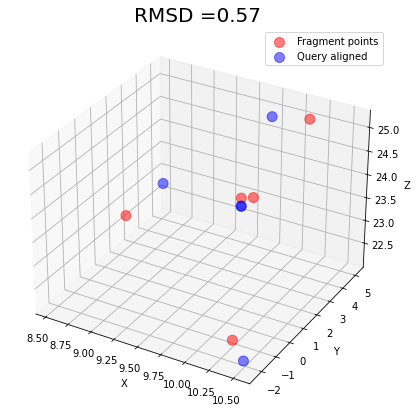

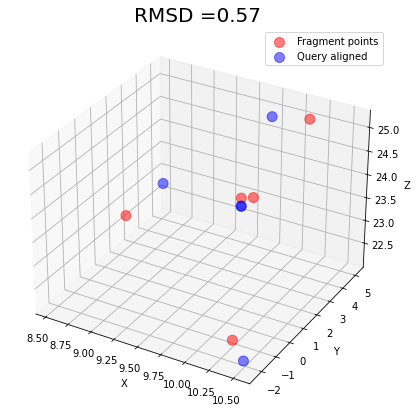

In [27]:
# get row of df with lowest RMSD to get fragment and query points
best_results = results_df.loc[results_df['RMSD'] == np.min(results_df['RMSD'])]
best_results = pd.DataFrame(best_results, columns=['RMSD', 'Fragment', 'Query'])

print(best_results)

for result in best_results.itertuples(index=False):

    # plot best result/s (sometimes multiple with same RMSD)
    ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
    # plot matrices for comparison 
    ax.scatter3D(result[1][:,0], result[1][:,1], result[1][:,2], label='Fragment points', color='r', s=100, alpha=0.5)
    ax.scatter3D(result[2][:,0], result[2][:,1], result[2][:,2], label='Query aligned', color='b', s=100, alpha=0.5)
    # set plot titles and labels
    ax.legend(loc='upper right')
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)
    plt.title(str('RMSD =' + str("{:.2f}".format(float(result[0])))), fontsize=20)



In [28]:
# print original fragment used as query
print('ORIGINAL FRAGMENT (query) POINTS:', test_points)

# print fragment points found in cloud for best alignment
print('FRAGMENT POINTS FOUND IN CLOUD:', np.array(best_results['Fragment']))

# print fragment aligned points
print('FRAGMENT (query) POINTS ALIGNED:', np.array(best_results['Query']))

ORIGINAL FRAGMENT (query) POINTS: [[ 4.199  2.401 22.489]
 [ 6.244  0.543 17.664]
 [ 1.978  3.214 23.166]
 [ 3.015  1.422 24.221]
 [ 3.015  1.422 24.221]]
FRAGMENT POINTS FOUND IN CLOUD: [array([[ 8.537,  2.282, 22.783],
        [10.339, -1.822, 22.355],
        [10.171,  4.696, 25.145],
        [ 9.435,  4.822, 23.01 ],
        [ 9.527,  5.107, 23.   ]]) array([[ 8.537,  2.282, 22.783],
                                          [10.339, -1.822, 22.355],
                                          [10.171,  4.696, 25.145],
                                          [ 9.527,  5.107, 23.   ],
                                          [ 9.435,  4.822, 23.01 ]])]
FRAGMENT (query) POINTS ALIGNED: [array([[ 8.86929911,  2.85221861, 23.53173289],
        [10.5215932 , -2.28011662, 22.17383993],
        [ 9.79294663,  4.56801276, 25.03342016],
        [ 9.41258053,  4.97244262, 22.77700351],
        [ 9.41258053,  4.97244262, 22.77700351]])
 array([[ 8.86929911,  2.85221861, 23.53173289],
       

In [29]:
print('minimum:', np.min(rmsd_vals))
print('minimum df:', np.min(results_df['RMSD']))

print('maximum:', np.max(rmsd_vals))
print('maximum df:', np.max(results_df['RMSD']))

print('mean:', np.mean(rmsd_vals))
print('mean:', np.mean(results_df['RMSD']))

minimum: 0.5660929333038245
minimum df: 0.5660929333038245
maximum: 7.285307539690706
maximum df: 7.285307539690706
mean: 4.208608505824273
mean: 4.208608505824273
